# 1. Lib Imports

In [1]:
import os
import pathlib
import re
import copy

from sys import getsizeof

import cv2
import xmltodict
import numpy as np
import pandas as pd
import tiffcapture as tc

from tifffile import imsave
from matplotlib import pyplot as pt

%matplotlib inline

# 2. Global vars definition

In [2]:
POSITION = 40
TIME_UNIT_FACTOR = 600
PIXEL_INCH_RATIO = .647
DIAMETER = 12

In [18]:
# path to exit data
exit_dat = '../results/40-47.csv'

# 3. Function defs

In [3]:
def removekey(d, key):
    """
    Remove a key from a  dictionary without destroying the reference
    to removed object (which might be used by other processes)
    """
    if key in d:
        r = dict(d)
        del r[key]
        return r

In [4]:
def parse_trees(links_tab):
    """
    Given 'links in tab statistics' from TrackMate.
    Construct data structures representing trees ('tree') and
    their branching ('branch') respectively.
    
    -   'tree' contains mapping of TREE_ID (which is the same as
        the id of root's SPOT_ID) to its associated tree.
        Each tree is in turn a map of TREE_BRANCH_ID
        (which is the branch's first spot's SPOT_ID)
        to its branch which is represented as list of SPOT_ID's.
    -   'branch' encodes how the tree is structured. It contains
        mapping of TREE_ID to the branching configuration.
        The branching configuration is encoded as mapping of
        BRANCH_ID to its two children's BRANCH_ID.
    """
    
    tree = {}
    branch = {}
    for track in links_tab.TRACK_ID.unique():
    
        sub = links_tab[links_tab.TRACK_ID == track]

        this_lines = {}
        this_branches = {}
        stack = []
    
        groot = sub.iloc[0][3] 
        print("Parsing tree %s" % groot)
        stack.append(groot)
    
        while len(stack) > 0:
        
            root = stack.pop()
            track = [root]
            print("Parsing subtree %s" % root)
            nsub = sub[sub.SPOT_SOURCE_ID == root]
        
            while nsub.index.size > 0:
                if nsub.index.size == 1:
                    this = nsub.iloc[0][4]
                    track.append(this)
                    nsub = sub[sub.SPOT_SOURCE_ID == this]
                else:
                    stack.append(nsub.iloc[0][4])
                    stack.append(nsub.iloc[1][4])
                    this_branches[root] = (nsub.iloc[0][4], nsub.iloc[1][4])
                    print("breaking")
                    break
                
            this_lines[root] = track
            print("adding branch %s" % root)
    
        print("Finishing...")
        tree[groot] = this_lines
        branch[groot] = this_branches
        
    return tree, branch

In [5]:
def extract_values(tree, spots_tab, colnames):
    """
    Extract varoius measurement values from spots statistics and save it
    in format similar to parsed tree. The list of values to be extracted
    from spots statistics is defined in 'colnames' 
    
    The information will be stored in following format:
    map(TYPE:(TREE_ID:TREE_BRANCH:list(VALUES))
    
    """
    
    vals = {}

    for tr in tree:
    
        print("extracting values for %s" % tr)
    
        for colname in colnames:
        
            val_tree = {}
        
            for br in tree[tr]:
            
                brkeys = tree[tr][br]
                brvals = [sits[sits.ID == x][colname].values[0] for x in brkeys]
            
                val_tree[br] = brvals
            
            if colname not in vals:
                vals[colname] = {}
            
            vals[colname][tr] = val_tree
            
    return vals

In [6]:
def filter_trees_by_time(tree, branch, tree_values, min_time=0, max_time=10):
    """
    Filter out trees which measurement time start before or after
    the time as defined in 'min_time' and 'max_time'.
    
    Measurement time is defined as the return value from TrackMate
    encoded as 'POSITION_T'
    """
    
    tree_values_filtered = {}
    tree = copy.deepcopy(tree)
    branch = copy.deepcopy(branch)

    for v in tree_values.keys():
        tree_values_filtered[v] = {}

    for key in tree_values['POSITION_T'].keys():
    
        if (tree_values['POSITION_T'][key][key][0] >= min_time) and (tree_values['POSITION_T'][key][key][0] <= max_time):
            for k in tree_values_filtered.keys():
                tree_values_filtered[k][key] = tree_values[k][key]
        else:
            tree = removekey(tree, key)
            branch = removekey(branch, key)
                
    return  tree, branch, tree_values_filtered 

In [7]:
def assign_tree_to_contours(tree_values, contours, pixel_inch_ratio=PIXEL_INCH_RATIO):
    """
    Given tree values and recognized contours, compute:
    
    -   'assocs': table listing recognized slit and the TREE_ID
        of singly-placed cell tree located in the slit
    -   'occupancy': list containing the number of cell trees
        located in a slit. NOTE: the list is not associated with
        ordering encoded in 'assocs'
    """

    occuppancy = {x:0 for x in range(len(contours))}
    cell_trees = []
    slits = []

    for tr in tree_values['POSITION_X'].keys():
    
        cell_trees.append(tr)

        x = tree_values['POSITION_X'][tr][tr][0] / pixel_inch_ratio
        y = tree_values['POSITION_Y'][tr][tr][0] / pixel_inch_ratio
    
        counter = 0
        match = 0
        matchloc = None
    
        for ct in cts:
        
            if cv2.pointPolygonTest(ct, (x, y), False) > 0:
                occuppancy[counter] += 1
                matchloc = counter
                match += 1
            counter +=  1
        
        if match == 0:
            slits.append(None)
        elif match == 1:
            slits.append(matchloc)
        else:
            print("Tree %s got too many matches" % tr)
        
    assocs = pd.DataFrame({'CELL_LINE': cell_trees, 'SLIT_ID': slits})
    occuppancy = np.array(list(occuppancy.values()))
    
    return assocs, occuppancy

In [8]:
def recognize_slits(img, minsize=6000, maxsize=float("inf")):
    """
    Reads contour mask picture and recognizes slits.
    Slit is defined as having size between $minsize and $maxsize
    This is a simplified version of get_contour
    """
    gray= cv2.cvtColor(img,
                       cv2.COLOR_BGR2GRAY)
    im2, contours, hierarchy  = cv2.findContours(gray, 
                                                 cv2.RETR_LIST,
                                                 cv2.CHAIN_APPROX_SIMPLE)
    
    cts = [ct for ct in contours if (cv2.contourArea(ct) > minsize and cv2.contourArea(ct) < maxsize)]
    return cts

# 3. Data import

In [17]:
track_path = '../test/eli-new-unsync-bf-%d/out-focus/merged/out/tracked/' % POSITION
with open(os.path.join(track_path, 'merged_Tracks.xml')) as fd:
    td = xmltodict.parse(fd.read())
    
with open(os.path.join(track_path, 'merged.xml')) as fd:
    sd = xmltodict.parse(fd.read())
    
ss = pd.read_csv(os.path.join(track_path, 'All Spots statistics.csv'))
ts = pd.read_csv(os.path.join(track_path, 'Track statistics.csv'))
ba = pd.read_csv(os.path.join(track_path, 'Links in tracks statistics.csv'))
sits = pd.read_csv(os.path.join(track_path, 'Spots in tracks statistics.csv'))

## TODO: include the last one file (branch statistics)

# 4. General data observation
## 4.1 Links in tracks statistics

In [18]:
ba.columns

Index([' ', 'Label', 'TRACK_ID', 'SPOT_SOURCE_ID', 'SPOT_TARGET_ID',
       'LINK_COST', 'EDGE_TIME', 'EDGE_X_LOCATION', 'EDGE_Y_LOCATION',
       'EDGE_Z_LOCATION', 'VELOCITY', 'DISPLACEMENT', 'MANUAL_COLOR'],
      dtype='object')

In [19]:
ba

,,Label,TRACK_ID,SPOT_SOURCE_ID,SPOT_TARGET_ID,LINK_COST,EDGE_TIME,EDGE_X_LOCATION,EDGE_Y_LOCATION,EDGE_Z_LOCATION,VELOCITY,DISPLACEMENT,MANUAL_COLOR
0,1,(ID1194518 : ID1211788),0,1194518,1211788,6.698,300,1259.062,1037.788,0,0.004,2.588,None
1,2,(ID1211788 : ID1200399),0,1211788,1200399,26.791,900,1260.356,1035.200,0,0.009,5.176,None
2,3,(ID1200399 : ID1206961),0,1200399,1206961,6.698,1500,1259.062,1032.612,0,0.004,2.588,None
3,4,(ID1206961 : ID1217319),0,1206961,1217319,13.395,2100,1256.474,1033.906,0,0.006,3.660,None
4,5,(ID1217319 : ID1227877),0,1217319,1227877,53.582,2700,1257.768,1037.788,0,0.012,7.320,None
5,6,(ID1227877 : ID1227151),0,1227877,1227151,66.977,3300,1264.238,1039.082,0,0.014,8.184,None
6,7,(ID1227151 : ID1233878),0,1227151,1233878,6.698,3900,1269.414,1037.788,0,0.004,2.588,None
7,8,(ID1233878 : ID1239241),0,1233878,1239241,26.791,4500,1268.120,1037.788,0,0.009,5.176,None
8,9,(ID1239241 : ID1244677),0,1239241,1244677,6.698,5100,1265.532,1039.082,0,0.004,2.588,None
9,10,(ID1244677 : ID1249997),0,1244677,1249997,33.489,5700,1262.944,1039.082,0,0.010,5.787,None


## 4.2 Track statistics

In [20]:
ts.columns

Index([' ', 'Label', 'NUMBER_SPOTS', 'NUMBER_GAPS', 'LONGEST_GAP',
       'NUMBER_SPLITS', 'NUMBER_MERGES', 'NUMBER_COMPLEX', 'TRACK_DURATION',
       'TRACK_START', 'TRACK_STOP', 'TRACK_DISPLACEMENT', 'TRACK_INDEX',
       'TRACK_ID', 'TRACK_X_LOCATION', 'TRACK_Y_LOCATION', 'TRACK_Z_LOCATION',
       'TRACK_MEAN_SPEED', 'TRACK_MAX_SPEED', 'TRACK_MIN_SPEED',
       'TRACK_MEDIAN_SPEED', 'TRACK_STD_SPEED', 'TRACK_MEAN_QUALITY',
       'TRACK_MAX_QUALITY', 'TRACK_MIN_QUALITY', 'TRACK_MEDIAN_QUALITY',
       'TRACK_STD_QUALITY'],
      dtype='object')

In [21]:
ts

,,Label,NUMBER_SPOTS,NUMBER_GAPS,LONGEST_GAP,NUMBER_SPLITS,NUMBER_MERGES,NUMBER_COMPLEX,TRACK_DURATION,TRACK_START,...,TRACK_MEAN_SPEED,TRACK_MAX_SPEED,TRACK_MIN_SPEED,TRACK_MEDIAN_SPEED,TRACK_STD_SPEED,TRACK_MEAN_QUALITY,TRACK_MAX_QUALITY,TRACK_MIN_QUALITY,TRACK_MEDIAN_QUALITY,TRACK_STD_QUALITY
0,1,Track_0,77,15,5,1,0,0,63600,0,...,0.010000,0.033,0.000,0.009,8.000000e-03,8.166,18.440,3.715,7.712,3.426
1,2,Track_1,225,18,5,9,0,0,106800,0,...,0.009000,0.031,0.000,0.006,6.000000e-03,10.161,23.621,3.862,9.368,4.394
2,3,Track_2,9,1,1,0,0,0,5400,0,...,0.007000,0.014,0.000,0.009,5.000000e-03,16.193,22.593,3.731,17.296,5.662
3,4,Track_3,256,12,1,0,0,0,160200,0,...,0.007000,0.019,0.000,0.006,5.000000e-03,12.191,28.368,3.740,11.326,5.182
4,5,Track_4,263,32,5,6,0,0,131400,0,...,0.009000,0.031,0.000,0.006,6.000000e-03,9.862,26.994,3.753,8.984,4.325
5,6,Track_5,38,3,1,0,0,0,24000,0,...,0.009000,0.026,0.000,0.006,6.000000e-03,10.392,30.351,3.928,9.070,4.967
6,7,Track_6,108,7,3,0,0,0,71400,0,...,0.007000,0.027,0.000,0.006,5.000000e-03,11.192,24.070,3.830,10.993,4.611
7,8,Track_7,49,4,4,0,0,0,36000,0,...,0.003000,0.014,0.000,0.004,4.000000e-03,11.015,22.068,3.718,9.793,5.856
8,9,Track_8,2,0,0,0,0,0,600,0,...,0.010000,0.010,0.010,0.010,NaN,15.767,25.902,5.632,25.902,10.135
9,10,Track_9,107,12,3,1,0,0,75000,0,...,0.010000,0.030,0.000,0.009,7.000000e-03,8.925,23.933,3.771,8.239,3.967


## 4.3 Spots Statistics

In [22]:
ss.columns

Index([' ', 'Label', 'ID', 'TRACK_ID', 'QUALITY', 'POSITION_X', 'POSITION_Y',
       'POSITION_Z', 'POSITION_T', 'FRAME', 'RADIUS', 'VISIBILITY',
       'MANUAL_COLOR', 'MEAN_INTENSITY', 'MEDIAN_INTENSITY', 'MIN_INTENSITY',
       'MAX_INTENSITY', 'TOTAL_INTENSITY', 'STANDARD_DEVIATION',
       'ESTIMATED_DIAMETER', 'CONTRAST', 'SNR'],
      dtype='object')

In [23]:
ss

,,Label,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,...,MANUAL_COLOR,MEAN_INTENSITY,MEDIAN_INTENSITY,MIN_INTENSITY,MAX_INTENSITY,TOTAL_INTENSITY,STANDARD_DEVIATION,ESTIMATED_DIAMETER,CONTRAST,SNR
0,1,ID1194004,1194004,1,17.275,1206.008,879.920,0,0,0,...,-10921639,22.601,0,0,242,11052,51.411,5.708,1.000,0.440
1,2,ID1194009,1194009,8,5.632,31.056,885.096,0,0,0,...,-10921639,9.746,0,0,182,4766,28.403,3.000,1.000,0.343
2,3,ID1195067,1195067,29,9.758,401.140,1174.952,0,0,0,...,-10921639,12.223,0,0,230,5977,34.332,6.212,0.708,0.295
3,4,ID1194040,1194040,30,16.232,701.348,898.036,0,0,0,...,-10921639,21.499,0,0,208,10513,45.368,9.513,1.000,0.474
4,5,ID1194064,1194064,41,6.688,582.300,905.800,0,0,0,...,-10921639,10.877,0,0,209,5319,31.088,28.500,0.927,0.337
5,6,ID1189969,1189969,43,19.531,672.880,38.820,0,0,0,...,-10921639,17.775,0,0,243,8692,50.424,5.778,1.000,0.353
6,7,ID1193027,1193027,47,7.979,194.100,670.292,0,0,0,...,-10921639,5.047,0,0,226,2468,26.347,3.000,0.966,0.188
7,8,ID1189952,1189952,48,21.449,553.832,36.232,0,0,0,...,-10921639,22.348,0,0,246,10928,56.634,5.911,0.723,0.331
8,9,ID1195084,1195084,59,18.332,385.612,1180.128,0,0,0,...,-10921639,23.221,0,0,243,11355,56.821,3.000,0.857,0.377
9,10,ID1195107,1195107,79,14.869,18.116,1190.480,0,0,0,...,-10921639,14.577,0,0,240,7128,43.024,5.904,0.958,0.332


In [24]:
ss[ss.ID == ss.ID.unique()[1]]

,,Label,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,...,MANUAL_COLOR,MEAN_INTENSITY,MEDIAN_INTENSITY,MIN_INTENSITY,MAX_INTENSITY,TOTAL_INTENSITY,STANDARD_DEVIATION,ESTIMATED_DIAMETER,CONTRAST,SNR
1,2,ID1194009,1194009,8,5.632,31.056,885.096,0,0,0,...,-10921639,9.746,0,0,182,4766,28.403,3.0,1.0,0.343


In [25]:
ss[ss.TRACK_ID == ss.TRACK_ID.unique()[1]]

,,Label,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,...,MANUAL_COLOR,MEAN_INTENSITY,MEDIAN_INTENSITY,MIN_INTENSITY,MAX_INTENSITY,TOTAL_INTENSITY,STANDARD_DEVIATION,ESTIMATED_DIAMETER,CONTRAST,SNR
1,2,ID1194009,1194009,8,5.632,31.056,885.096,0,0,0,...,-10921639,9.746,0,0,182,4766,28.403,3.000,1.000,0.343
194,195,ID1211291,1211291,8,25.902,33.644,890.272,0,600,1,...,-10921639,21.822,0,0,253,10671,55.250,6.048,0.954,0.386


In [26]:
ss['TRACK_ID']

0           1
1           8
2          29
3          30
4          41
5          43
6          47
7          48
8          59
9          79
10         82
11       None
12       None
13         11
14         12
15         20
16         23
17         24
18         32
19         37
20         63
21         68
22         87
23         90
24         92
25          2
26         13
27         17
28         31
29         35
         ... 
28225     236
28226     188
28227     640
28228    None
28229    None
28230      85
28231     543
28232     495
28233      34
28234     300
28235    None
28236      85
28237     635
28238    None
28239      94
28240    None
28241     627
28242    None
28243     498
28244     549
28245     637
28246     194
28247      30
28248     586
28249    None
28250     465
28251     560
28252     618
28253    None
28254    None
Name: TRACK_ID, dtype: object

In [27]:
ss.groupby('TRACK_ID').size().sort_values(ascending=False)

TRACK_ID
None    1890
85       475
16       408
37       392
36       376
20       363
70       362
72       358
12       330
63       325
64       318
30       314
59       293
13       285
83       278
53       276
91       275
44       274
75       268
32       267
4        263
23       261
94       260
39       260
24       258
3        256
45       253
50       253
71       247
41       246
        ... 
458        2
460        2
462        2
642        2
185        2
184        2
473        2
485        2
442        2
211        2
245        2
218        2
403        2
406        2
631        2
409        2
632        2
235        2
634        2
418        2
228        2
61         2
421        2
422        2
224        2
427        2
222        2
429        2
220        2
596        2
dtype: int64

In [28]:
largest = ss.groupby('TRACK_ID').size().sort_values(ascending=False).reset_index(drop=False).values[1,0]

In [29]:
largest_track = ss[ss.TRACK_ID == largest]
largest_track_occ = largest_track.groupby('POSITION_T').size().reset_index(drop=False)

In [30]:
largest_track

,,Label,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,...,MANUAL_COLOR,MEAN_INTENSITY,MEDIAN_INTENSITY,MIN_INTENSITY,MAX_INTENSITY,TOTAL_INTENSITY,STANDARD_DEVIATION,ESTIMATED_DIAMETER,CONTRAST,SNR
48,49,ID1193447,1193447,85,11.981,1273.296,766.048,0,0,0,...,-10921639,12.339,0,0,249,6034,44.086,3.000,1.000,0.280
147,148,ID1210765,1210765,85,16.017,1275.884,766.048,0,600,1,...,-10921639,14.190,0,0,247,6939,42.649,5.378,0.999,0.333
245,246,ID1199336,1199336,85,13.816,1275.884,763.460,0,1200,2,...,-10921639,15.501,0,0,249,7580,47.967,5.592,1.000,0.323
382,383,ID1205075,1205075,85,4.890,1275.884,763.460,0,1800,3,...,-10921639,7.720,0,0,136,3775,23.561,3.000,0.853,0.302
471,472,ID1216409,1216409,85,11.005,1278.472,766.048,0,2400,4,...,-10921639,11.636,0,0,251,5690,38.308,3.000,0.999,0.304
511,512,ID1225810,1225810,85,5.538,1283.648,758.284,0,3000,5,...,-10921639,12.213,0,0,200,5972,33.146,3.000,0.638,0.287
632,633,ID1225190,1225190,85,12.267,1283.648,763.460,0,3600,6,...,-10921639,13.493,0,0,226,6598,42.117,28.500,0.262,0.133
687,688,ID1232978,1232978,85,16.674,1286.236,760.872,0,4200,7,...,-10921639,17.761,0,0,242,8685,48.277,5.837,0.989,0.366
807,808,ID1238295,1238295,85,14.235,1288.824,758.284,0,4800,8,...,-10921639,16.380,0,0,249,8010,47.276,3.000,0.933,0.335
962,963,ID1243732,1243732,85,11.985,1281.060,763.460,0,5400,9,...,-10921639,14.965,0,0,248,7318,45.486,3.000,0.786,0.290


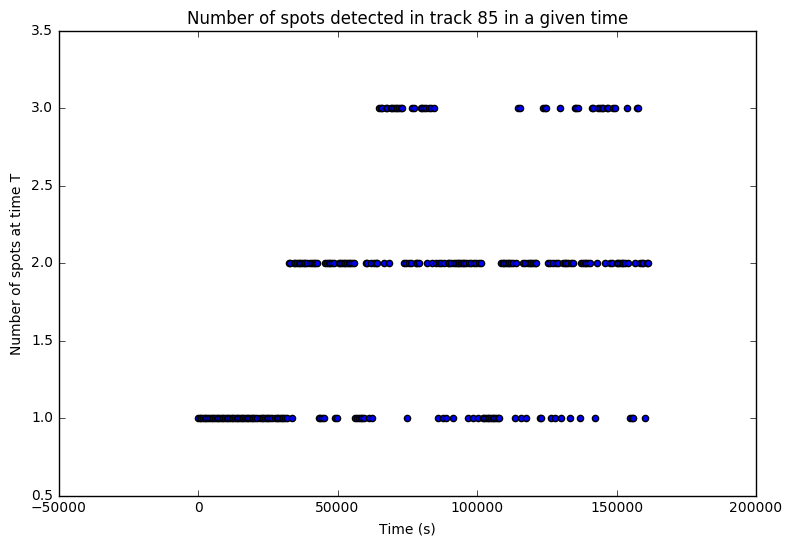

In [31]:
pt.scatter(largest_track_occ.POSITION_T, largest_track_occ[0])

frame = pt.gcf()
frame.set_size_inches(9, 6)

pt.title("Number of spots detected in track %s in a given time" % largest)
pt.xlabel("Time (s)")
pt.ylabel("Number of spots at time T")

# 5. Data Import  and Parsing

In [32]:
tree, branch = parse_trees(ba)

Parsing tree 1194518
Parsing subtree 1194518
breaking
adding branch 1194518
Parsing subtree 1616709
adding branch 1616709
Parsing subtree 1616672
adding branch 1616672
Finishing...
Parsing tree 1194004
Parsing subtree 1194004
breaking
adding branch 1194004
Parsing subtree 1292352
adding branch 1292352
Parsing subtree 1292395
breaking
adding branch 1292395
Parsing subtree 1340129
adding branch 1340129
Parsing subtree 1340182
breaking
adding branch 1340182
Parsing subtree 1427683
breaking
adding branch 1427683
Parsing subtree 1500162
adding branch 1500162
Parsing subtree 1500163
breaking
adding branch 1500163
Parsing subtree 1657726
adding branch 1657726
Parsing subtree 1657740
breaking
adding branch 1657740
Parsing subtree 1747583
breaking
adding branch 1747583
Parsing subtree 1876278
breaking
adding branch 1876278
Parsing subtree 1933311
breaking
adding branch 1933311
Parsing subtree 2209219
adding branch 2209219
Parsing subtree 2209158
adding branch 2209158
Parsing subtree 1933287
add

In [33]:
svals = extract_values(tree, sits, ['POSITION_T', 'POSITION_X', 'POSITION_Y', 'TOTAL_INTENSITY', 'QUALITY'])

extracting values for 2230337
extracting values for 2495659
extracting values for 2242566
extracting values for 1234701
extracting values for 2231127
extracting values for 1854476
extracting values for 2567182
extracting values for 2869263
extracting values for 1417232
extracting values for 1234962
extracting values for 2535443
extracting values for 1194004
extracting values for 2756782
extracting values for 2805782
extracting values for 1845271
extracting values for 1194009
extracting values for 1266714
extracting values for 2116637
extracting values for 1807391
extracting values for 2144289
extracting values for 1494052
extracting values for 1219622
extracting values for 2844337
extracting values for 2684252
extracting values for 1731628
extracting values for 2604597
extracting values for 1506350
extracting values for 1841199
extracting values for 2730032
extracting values for 1916977
extracting values for 2772019
extracting values for 1790004
extracting values for 1852469
extracting

# 6. Filter tree out by time

In [34]:
tree, branch, svals = filter_trees_by_time(tree, branch, svals)

In [35]:
svals

{'POSITION_T': {1189833: {1189833: [0,
    600,
    1200,
    1800,
    2400,
    3000,
    3600,
    4200,
    4800,
    5400,
    6000,
    6600,
    7200,
    7800,
    8400,
    9000,
    9600,
    10200,
    10800,
    11400,
    12000,
    12600,
    13200,
    13800,
    14400,
    15000,
    15600,
    16200,
    16800,
    17400,
    18000,
    18600,
    19200,
    19800,
    20400,
    21000,
    21600,
    22200,
    22800,
    23400,
    24000,
    24600,
    25200,
    25800,
    26400,
    27000,
    27600,
    28200,
    28800,
    29400,
    30000,
    30600,
    31200,
    31800,
    32400,
    33000,
    33600,
    34200,
    34800,
    35400,
    36000,
    36600,
    37200,
    37800,
    38400,
    39000,
    39600,
    40200,
    40800,
    41400,
    42000,
    42600,
    43200,
    43800,
    44400,
    45000,
    45600,
    46200,
    46800,
    47400,
    48000,
    48600,
    49200,
    49800,
    50400,
    51000,
    51600,
    52200,
    52800,
    53400,

# 7. Slit Contour Analysis

In [9]:
path = '../test/eli-new-unsync-bf-%d/in-focus/before' % POSITION
impath = 'bf_in-focusxy%dc1c1-mask.tif' % POSITION
imorigpath = 'bf_in-focusxy%dc1c1.tif' % POSITION
immask = '../test/eli-new-unsync-bf-%d/out-focus/merged/merged.tif' % POSITION

im = cv2.imread(os.path.join(path, impath))
imorig = cv2.imread(os.path.join(path, imorigpath))
immask = cv2.imread(immask)

gray= cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
im2, contours, hierarchy  = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

In [10]:
plot_others = False

In [11]:
## show the 0-th contour in one element contour list

if plot_others:
    cnt = contours[4]
    cv2.drawContours(im, [cnt], 0, (255, 0, 0), 3)
    cv2.imshow("Keypoints", im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
## show all contours in the lsist

if plot_others:
    cv2.drawContours(im, contours, -1, (255, 0, 0),1)
    cv2.imshow("Keypoints", im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

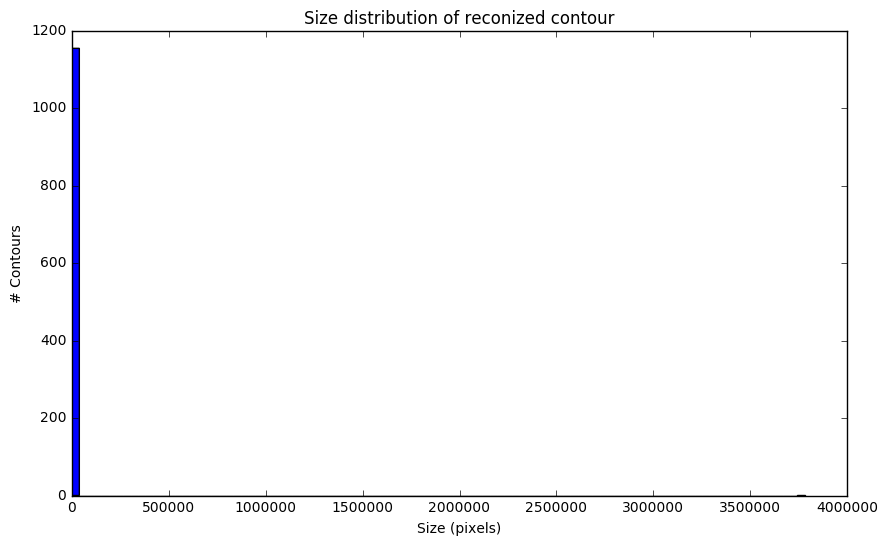

In [12]:
pt.hist(np.array([cv2.contourArea(x) for x  in contours]), bins=100)
pt.gcf().set_size_inches(10, 6)

pt.title("Size distribution of reconized contour")
pt.xlabel("Size (pixels)")
pt.ylabel("# Contours")

9343.0


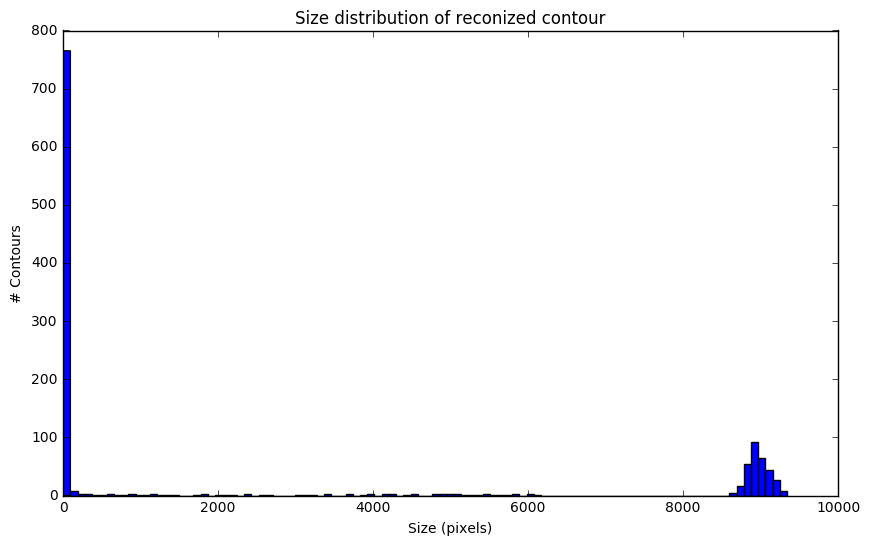

In [13]:
## plot the size of contours

sizes = np.array([cv2.contourArea(x) for x  in contours])
sizes = sizes[sizes < sizes.max()]

pt.title("Size distribution of reconized contour")
pt.xlabel("Size (pixels)")
pt.ylabel("# Contours")
pt.hist(sizes, bins=100)
print(max(sizes))
pt.gcf().set_size_inches(10, 6)

9343.0


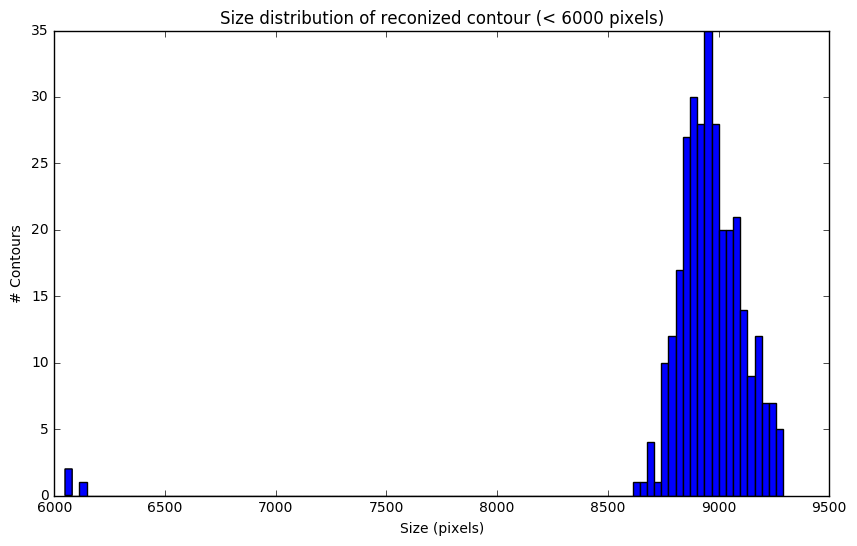

In [14]:
## plot the size of putative correct contours

pt.hist(sizes[(sizes < sizes.max()) & (sizes > 6000)], bins=100)
print(max(sizes))
pt.title("Size distribution of reconized contour (< 6000 pixels)")
pt.xlabel("Size (pixels)")
pt.ylabel("# Contours")
pt.gcf().set_size_inches(10, 6)

In [15]:
sizes = np.array([cv2.contourArea(x) for x  in contours])
sizes = sizes[(sizes < sizes.max()) & (sizes > 6000)]

cts  = []
dist = []

for ct in contours:
    ct_area = cv2.contourArea(ct)
    if (ct_area < 10000) and (ct_area > 7000):
        cts.append(ct)
        dist.append(ct_area)

In [69]:
## draw contours and write file

imc = im.copy()
cv2.drawContours(imc, cts, -1, (255, 0, 0), 2)
cv2.imwrite(os.path.join(path, 'im_contours.tiff'), imc);

In [70]:
## check whether a point lies inside/on/outside the contour
cv2.pointPolygonTest(contours[0], (1199, 2046), False)

-1.0

In [71]:
## distance between a point and the contour
cv2.pointPolygonTest(contours[0], (1199, 2046), True) <= 0

True

# 8. Tree-Slit Assignment

In [36]:
assocs, occuppancy = assign_tree_to_contours(svals, cts)

In [37]:
print("# of trees in slit: %d" % assocs[~assocs.SLIT_ID.isnull()].index.size)
print("Ratio  of cell lines not identified to specific slit: %f" % (assocs[assocs.SLIT_ID.isnull()].index.size / assocs.index.size))
print("ratio of slit not associated with any cell lineage: %f" % (occuppancy[occuppancy == 0].size / occuppancy.size))

# of trees in slit: 75
Ratio  of cell lines not identified to specific slit: 0.218750
ratio of slit not associated with any cell lineage: 0.783871


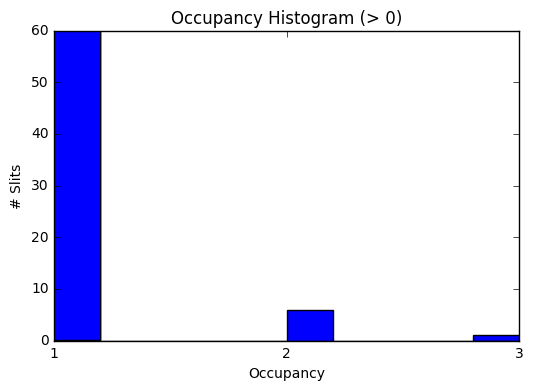

In [38]:
pt.hist(occuppancy[occuppancy > 0])
pt.xticks(np.array(range(max(occuppancy))) + 1)
pt.xlabel("Occupancy")
pt.ylabel("# Slits")
pt.title("Occupancy Histogram (> 0)")

# pt.gcf().set_size_inches(8, 5)

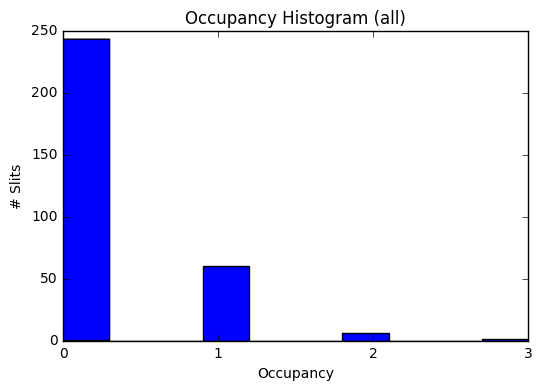

In [39]:
pt.hist(list(occuppancy))
pt.xticks(range(max(occuppancy) + 1))
pt.xlabel("Occupancy")
pt.ylabel("# Slits")
pt.title("Occupancy Histogram (all)")

# pt.gcf().set_size_inches(8, 5)

In [40]:
lam = sum(occuppancy)  / len(occuppancy)
print(lam)

from scipy.misc import factorial
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

x = np.arange(0, 3, 0.05)
y = np.array([poisson(v, lam) for v in x]) * len(occuppancy)

0.241935483871


[0, 1, 2, 3]

In [47]:
pd.Series(list(occuppancy)).value_counts().index.tolist()

[0, 1, 2, 3]

In [49]:
x

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,
        1.35,  1.4 ,  1.45,  1.5 ,  1.55,  1.6 ,  1.65,  1.7 ,  1.75,
        1.8 ,  1.85,  1.9 ,  1.95,  2.  ,  2.05,  2.1 ,  2.15,  2.2 ,
        2.25,  2.3 ,  2.35,  2.4 ,  2.45,  2.5 ,  2.55,  2.6 ,  2.65,
        2.7 ,  2.75,  2.8 ,  2.85,  2.9 ,  2.95])

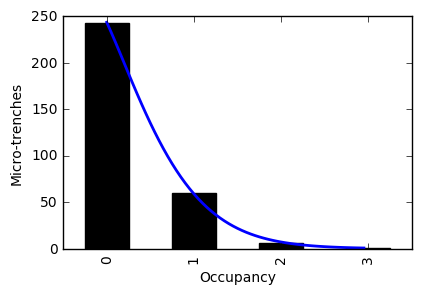

In [50]:
ax = pd.Series(list(occuppancy)).value_counts().plot(kind="bar", color="black")
pt.ylabel("Micro-trenches")
pt.xlabel("Occupancy")
pt.gcf().set_size_inches(4.5, 3)
ax.plot(x, y, linewidth=2)
# pt.xticks(pd.Series(list(occuppancy)).value_counts().index.tolist(), x, rotation='vertical')

pt.savefig("D:/workspace/msc-thesis-manu/images/occupancy_distribution.pdf")

### IX. Measurement of various slit recognition methods

In [7]:
pth = '../test/eli-new-unsync-bf-47/in-focus/before/bf_in-focusxy47c1c1_brightness-basic-robust-fill.tif'
imin = cv2.imread(pth)
ctrout = recognize_slits(imin)
print(len(ctrout))

254


In [8]:
pth = '../test/eli-new-unsync-bf-47/in-focus/before/bf_in-focusxy47c1c1-mask.tif'
imin = cv2.imread(pth)
ctrout = recognize_slits(imin)
print(len(ctrout))

225


In [9]:
pth = '../test/eli-new-unsync-bf-47/in-focus/before/test-slit-segmentation/04-fill-holes.tif'
imin = cv2.imread(pth)
ctrout = recognize_slits(imin)
print(len(ctrout))

226
